In [5]:
import numpy as np
import scipy.optimize
import scipy.special
import itertools
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
# Read input from a file and transform each line
input_file = 'facebook.mtx'  # Change this to your file's name
output_file = 'facebooks.mtx'

# Open the input file and output file
with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    for line in infile:
        # Split the line into two numbers, convert to integers, and increment by 1
        a, b = map(int, line.strip().split())
        a += 1
        b += 1
        # Write the transformed line to the output file
        outfile.write(f"{a} {b}\n")

print("Transformation complete. Check for the result.")

Transformation complete. Check for the result.


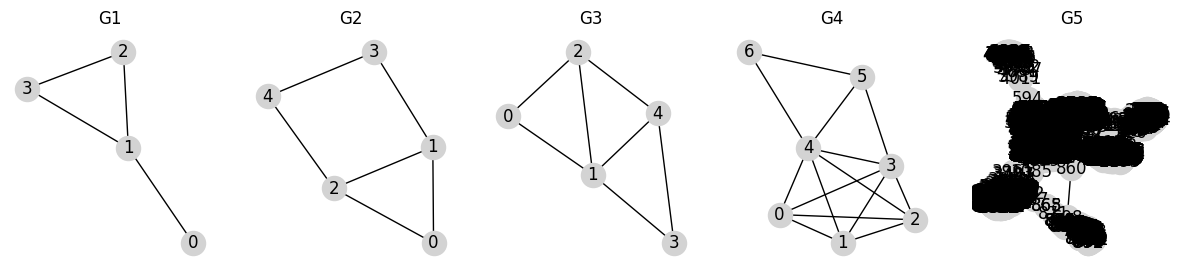

In [ ]:
# Stop sign graph
G1 = nx.Graph(incoming_graph_data=[
    (0,1),
    (1,2), (1,3),
    (2,3)
])
# Initialize an empty list to store the tuples
result = []
# Open and read the file
with open('./facebook.mtx', 'r') as file:
    for line in file:
        # Split each line into two integers
        a, b = map(int, line.split())
        
        # Adjust to 0-based indexing and create the tuple
        result.append((a - 1, b - 1))

G5 = nx.Graph(incoming_graph_data=result)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (15,3))
ax = axes.flatten()
graphs = [G1,G2,G3,G4,G5]


for i in range(len(graphs)):
    nx.draw_networkx(graphs[i], node_color = "lightgray", ax=ax[i])
    ax[i].set_axis_off()
    ax[i].title.set_text("G"+str(i+1))

plt.show()

In [17]:
nx.is_connected(G5)

True

In [18]:
import numpy as np
import networkx as nx
import random

def covering_random_walk(P):
    """
    Perform a covering random walk on a transition matrix P.
    """
    n = len(P)
    s = np.random.randint(0, high=n)  # Start at a random node
    discovered = [s]
    states = [s] # we don't need this
    discovered_by = [None]
    
    while len(discovered) < n:
        next_s = np.random.choice(n, p=P[s])  # Choose next state based on transition probabilities
        states.append(next_s)
        if next_s not in discovered:
            discovered.append(next_s)
            discovered_by.append(s)
        s = next_s
        
    return states, discovered, discovered_by

def transition_matrix_uniform(G):
    """
    Create a uniform transition matrix for the graph.
    """
    A = nx.to_numpy_array(G)  # Updated from to_numpy_matrix
    P = (A.T / A.sum(axis=1)).T  # Normalize rows to make probabilities
    return P

def transition_matrix_adapted(G):
    """
    Create an adapted transition matrix that accounts for node degrees.
    """
    degrees = np.array([d for _, d in G.degree])
    A = nx.to_numpy_array(G)
    P = A * np.outer(degrees, degrees)
    P = (P.T / P.sum(axis=1)).T  # Normalize rows to make probabilities
    return P

def sample_spanning_tree(G, P):
    """
    Return indices of edges in a sampled spanning tree.
    """
    _, discovered, discovered_by = covering_random_walk(P)
    subset_of_edges = [(discovered[i], discovered_by[i]) for i in range(1, len(discovered))]
    subset_of_ordered_edges = [(min(a, b), max(a, b)) for a, b in subset_of_edges]
    edges = list(G.edges)
    indices_of_edges = [edges.index(e) for e in subset_of_ordered_edges]
    return np.sort(indices_of_edges)

def MC_edge_probability(G, P, K=1000):
    """
    Monte Carlo estimation of edge probability in spanning trees.
    """
    count = np.zeros(G.number_of_edges())
    for _ in range(K):
        indices = sample_spanning_tree(G, P)
        for i in indices:
            count[i] += 1
    return count / K


In [19]:
import numpy as np
import networkx as nx
import random

def get_max_length(graph: nx.Graph, T, gamma):
    """Calculate the maximum length of random walks."""
    n = graph.number_of_nodes()
    m = graph.number_of_edges()
    # Calculate all degree's power of 2 of node without vertex in T
    d = np.array([degree for node, degree in dict(graph.degree()).items() if node != list(T)[0]])
    d_norm = np.linalg.norm(d)
    
    # Let A is a adj matrix of graph without vertex in T
    A = nx.to_numpy_array(graph)
    A = np.delete(A, list(T)[0], axis=0)
    A = np.delete(A, list(T)[0], axis=1)
    
    spectral_radius = max(abs(np.linalg.eigvals(A)))
    max_length = int((np.log(m * gamma / ((np.sqrt(n - 1))) * d_norm) / np.log(spectral_radius)))
    print((np.log(m * gamma / ((np.sqrt(n - 1))) * d_norm) / np.log(spectral_radius)))
    return max_length

def covering_random_walk(P, s, T, max_length):
    """
    Perform a covering random walk on a transition matrix P.
    """
    n = len(P)
    discovered = [s]
    states = [s] # Ignore
    discovered_by = [None]
    s_to_T_position = 0
    max_length_count = 0
    while max_length_count < max_length and len(discovered) < n and T not in discovered:
        next_s = np.random.choice(n, p=P[s])  # Choose next state based on transition probabilities
        states.append(next_s)
        max_length_count += 1
        if next_s not in discovered:
            s_to_T_position += 1
            discovered.append(next_s)
            discovered_by.append(s)
            s = next_s
    if T != discovered[-1]:
        s_to_T_position = 0
    return states, discovered, s_to_T_position, discovered_by

def transition_matrix_uniform(G):
    """
    Create a uniform transition matrix for the graph.
    """
    A = nx.to_numpy_array(G)  # Updated from to_numpy_matrix
    P = (A.T / A.sum(axis=1)).T  # Normalize rows to make probabilities
    return P

def sample_spanning_tree(G:nx.graph, P, s, T, max_length):
    """
    Return indices of edges in a sampled spanning tree.
    """
    _, discovered, s_to_T_position, discovered_by = covering_random_walk(P, s, T, max_length)
    subset_of_edges = [(discovered[i], discovered_by[i]) for i in range(1, len(discovered))]
    subset_of_ordered_edges = [(min(a, b), max(a, b)) for a, b in subset_of_edges]
    edges = list(G.edges)
    indices_of_edges = [edges.index(e) for e in subset_of_ordered_edges]
    return subset_of_ordered_edges, s_to_T_position, np.sort(indices_of_edges)

def MC_edge_probability(G:nx.Graph, T, max_length, epsilon):
    """
    G: Input graph
    T: target nodes list
    """
    T = list(T)[0]
    n = G.number_of_nodes()
    # Get transition matrix of graph
    P = transition_matrix_uniform(G)
    C = np.zeros(n)
    R = np.zeros(n)
    rho = int(np.log(n) / epsilon**2)
    loop_times = int(rho/2)
    vertex_to_T = []
    for edge in G.edges():
        x, y = edge
        count = np.zeros(G.number_of_edges())
        for _ in range(loop_times):
            w1, st_pos1, ind_w1 = sample_spanning_tree(G, P, x, T, max_length)
            w2, st_pos2, ind_w2 = sample_spanning_tree(G, P, y, T, max_length)
            ind_w1 = list(ind_w1)
            ind_w2= list(ind_w2)
            if st_pos2 and st_pos1:
                vertex_to_T.append((x, w1, st_pos1))
                vertex_to_T.append((y, w2, st_pos2))
    for vertex, walk, value in vertex_to_T:
        if vertex != T:
            weight = 1 / value
            C[vertex] += weight / rho
    for vertex, weight in enumerate(C):
        if weight == 0:
            R[vertex] = 0
        else:
            R[vertex] = 1 / weight
            R[vertex] = R[vertex]
    print(R)
    return count / rho


In [2]:
G = nx.Graph(incoming_graph_data=[(0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (0, 4)])
gamma = 0.95
epsilon = 0.005
T = {2}
# covering_random_walk(P)
max_length = get_max_length(G, T, gamma)
print(max_length)
MC_edge_probability(G, T, max_length, epsilon)

NameError: name 'get_max_length' is not defined

In [11]:
weights_uniform = [MC_edge_probability(G,transition_matrix_uniform(G)) for G in graphs]
weights_adapted = [MC_edge_probability(G,transition_matrix_adapted(G)) for G in graphs]

KeyboardInterrupt: 

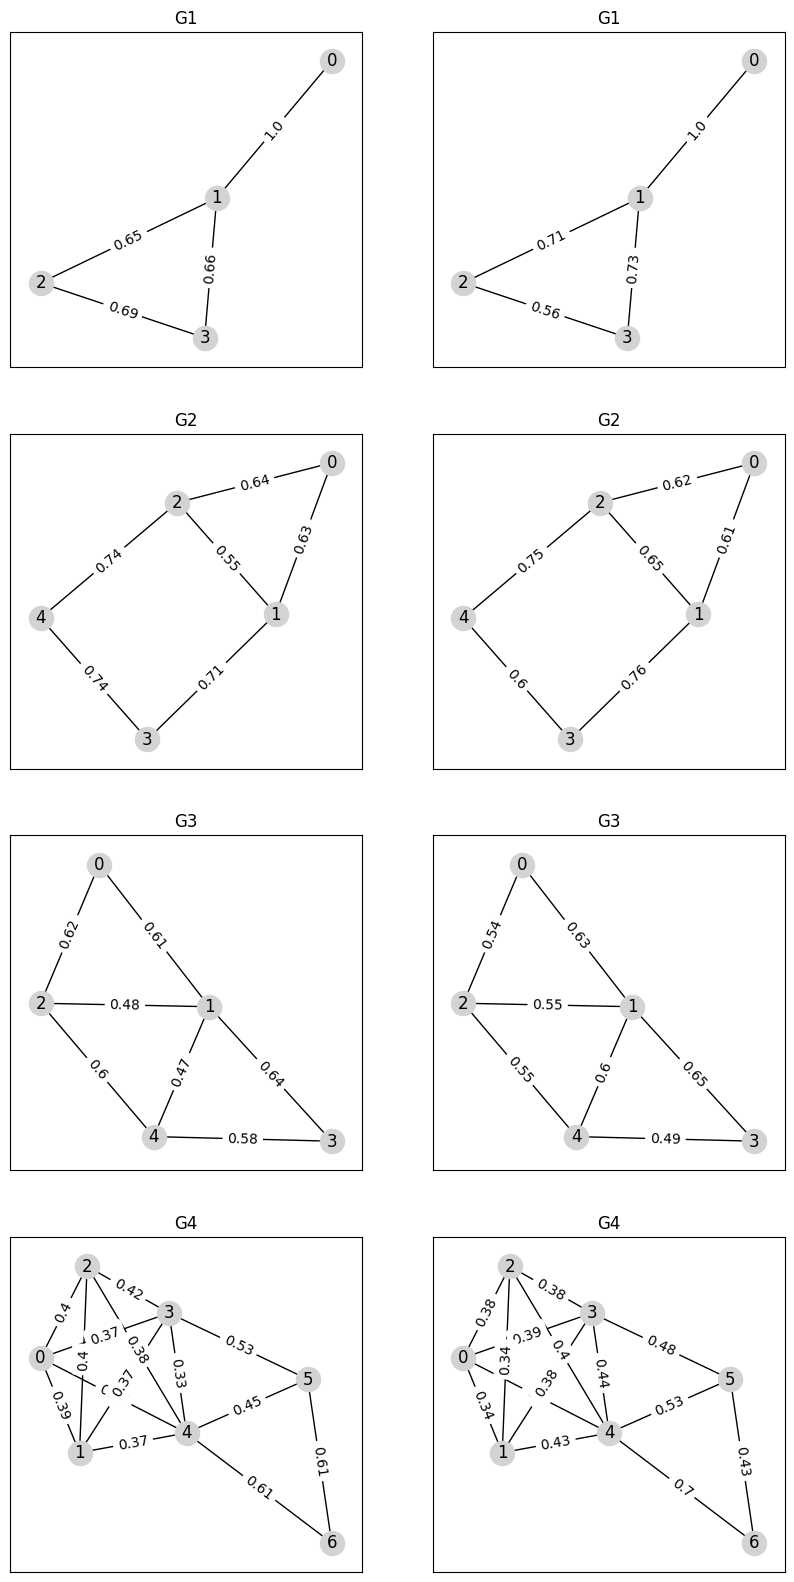

In [9]:
fig, axes = plt.subplots(nrows=len(graphs), ncols=2, figsize = (10,5*len(graphs)))
ax = axes.flatten()

for i in range(len(graphs)):
    pos = nx.spring_layout(graphs[i])
    nx.draw_networkx(graphs[i],pos = pos, node_color = "lightgray", ax=ax[2*i])
    labels = {list(graphs[i].edges)[j]: np.round(weights_uniform[i][j], decimals = 2) for j in range(graphs[i].size())}
    nx.draw_networkx_edge_labels(graphs[i],pos,edge_labels=labels, ax=ax[2*i])
    ax[2*i].title.set_text("G"+str(i+1))
    
    nx.draw_networkx(graphs[i],pos = pos, node_color = "lightgray", ax=ax[2*i+1])
    labels = {list(graphs[i].edges)[j]: np.round(weights_adapted[i][j], decimals = 2) for j in range(graphs[i].size())}
    nx.draw_networkx_edge_labels(graphs[i],pos,edge_labels=labels, ax=ax[2*i+1])
    ax[2*i+1].title.set_text("G"+str(i+1))

plt.show()